In [ ]:

import visio as v

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import visio as v

def contarPunts(roi):
    dst = np.zeros((roi.shape[0],roi.shape[1],3),dtype=np.uint8)
    dst[:,:,0] = roi[:,:]
    dst[:,:,1] = roi[:,:]
    dst[:,:,2] = roi[:,:]
    dst = cv.GaussianBlur(dst,(5,5),0)
    _,threshold = cv.threshold(dst,127,255,cv.THRESH_BINARY)    
    contours, hierarchy = cv.findContours(threshold[:,:,0],cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    punts = 0
    
    dst = cv.drawContours(dst,contours,-1,(255,127,0),1)
    #plt.figure()
    #plt.imshow(dst,'gray')
    for i,c in enumerate(contours):
        pare = hierarchy[0][i,3]
        if pare != -1:
            punts+=1
    return punts

if __name__ == '__main__':
    j0 = cv.imread('src/jugada/00.jpg')
    j1 = cv.imread('src/jugada/01.jpg')
    j2 = cv.imread('src/jugada/02.jpg')
    j3 = cv.imread('src/jugada/03.jpg')
    vis = v.Visio()
    
    #it 1
    vis.updateFrame(j0)
    out = vis.getTableData()
    #plt.figure()
    #plt.imshow(out,'gray')
    #it 2
    vis.updateFrame(j1)
    out = vis.getTableData()
    #plt.figure()
    #plt.imshow(out,'gray')
    #it 3
    vis.updateFrame(j2)
    out = vis.getTableData()
    
    vis.updateFrame(j3)
    out = vis.getTableData()
    print("rotacio:{}".format(vis.rotacioDefecte))
    plt.figure()
    plt.imshow(vis.rotatedFrame,'gray')
    
    final = vis.rotatedFrame
    arrayPatrons = []
    arrayPatrons.append(vis.patroV)
    arrayPatrons.append(vis.patroH)
    
    zonaMatch = int(min(vis.patroV.shape))
    #arrayPatrons.append(np.flip(vis.patroV))
    #arrayPatrons.append(np.flip(vis.patroH))
    
    estatPartida={'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
    
    print('zonaMatch: {}'.format(zonaMatch))
    found=[]
    for patro in arrayPatrons:  
        
        w, h = patro.shape[::-1]
        res = cv.matchTemplate(final,patro,cv.TM_CCOEFF_NORMED) #TM_SQDIFF_NORMED
        thr = 0.8
        loc = np.where( res >= thr)
        same=False
        for pt in zip(*loc[::-1]):  
            if len(found)==0:
                same=False
            else:
                same=False
                for f in found:
                    if pt[0] in (np.arange(f[0]-zonaMatch,f[0]+zonaMatch)):
                        if pt[1] in (np.arange(f[1]-zonaMatch,f[1]+zonaMatch)):
                            same = True
                            break
            if not same:
                found.append(pt)  
                top_left = pt
                bottom_right = (pt[0] + w, pt[1] + h)
                
                top_right = (bottom_right[0],top_left[1])
                bottom_left = (top_left[0],bottom_right[1])
                
                center = (int(top_left[0]+(round((top_right[0]-top_left[0])/2))) ,int(top_left[1]+(round((bottom_left[1]-top_left[1])/2))))


                orientacio = 1 #h
                alcada = vis.midaFitxa[0]
                amplada = vis.midaFitxa[1]
                if top_right[0]-top_left[0] < bottom_left[1]-top_left[1]:
                    orientacio=0
                    alcada = vis.midaFitxa[1]
                    amplada = vis.midaFitxa[0]


                estatPartida['taulell'][len(estatPartida['taulell'])]=[(center[0],center[1],amplada,alcada),[0,0],orientacio]  
                final = cv.rectangle(final, pt, (pt[0] + w, pt[1] + h), (0,127,255), 2)
        
       
    plt.figure()
    plt.imshow(final,'gray')
    cv.imwrite('fina.jpg',final)
    
    
    #idFitxa : [ (x,y,amplada,alçada), [ puntsEsquerra/Dalt, puntsDreta/Baix], orientació]
    for dic in estatPartida['taulell']:
        #print(estatPartida['taulell'][dic])
        x,y,w,h = estatPartida['taulell'][dic][0]
        puntsA=0
        puntsB=0
        if estatPartida['taulell'][dic][2]: # Vertical
            # ROI
            roi = final[y-round(h/2) : y,x-round(w/2) : x+round(w/2)] # Superior
            puntsA=contarPunts(roi)
            roi = final[y : y+round(h/2),x-round(w/2) : x+round(w/2)] # Inferior
            puntsB=contarPunts(roi)

        else: # Horitzontal
            # ROI
            roi = final[y-round(h/2) : y+round(h/2),x-round(w/2) : x] # Esquerra
            puntsA=contarPunts(roi)
            
            roi = final[y-round(h/2) : y+round(h/2),x : x+round(w/2)] # Dreta
            puntsB=contarPunts(roi)
        
        estatPartida['taulell'][dic][1]=[puntsA,puntsB]
    
    for d in estatPartida['taulell']:
        print("{}: {}".format(d,estatPartida['taulell'][d]))
    # ProcessarFrame():
    # si hi ha orientacio rotarla
    # si no hi ha patroFitxa, buscar-lo
    # Si hi patroFitxa, patternmatching
        # Recompte de punts 
    


9
59.931413650512695
0: [(340, 302, 44, 84), [0, 0], 1]
59.931413650512695
0: [(340, 302, 44, 84), [0, 0], 1]
59.931413650512695
0: [(340, 302, 44, 84), [0, 0], 1]


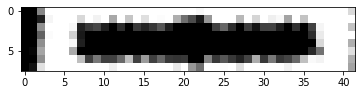

In [5]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math


class ModulVisio():
    ###############################################################################################
    def __init__(self, debug = False):
        self.debug = debug
        
        # mides en cm del taulell #
        self.midaTaulell =[60.0,65.0]
        self.midaMin = 10.0
        self.midaMax = 40.0      
        self.margeRobot = 5.0
        ###########################
        
        self.empty = True
        self.originalBackground = None
        self.fitxaFrame = None
        self.frame = None
        self.grayFrame = None
        self.rotatedFrame = None
        
        self.patroH = None
        self.patroV = None
        self.arrayPatrons = []
        
        self.midaFitxa = [0,0]
        self.rotacioDefecte = 0.0
        
        self.estatPartida = None
    ###############################################################################################
    
    def updateFrame(self,frame,debug=None):
        if debug is not None:
            self.debug = debug
        self.frame = frame
        self.grayFrame = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
        if self.originalBackground is None:
            self.originalBackground = self.grayFrame
        else:
            self.fitxaFrame = cv.absdiff(self.grayFrame,self.originalBackground)
#             self.fitxaFrame[self.fitxaFrame<127]=0
#             self.fitxaFrame[self.fitxaFrame!=0]=255
            if self.empty:
                self.getFirstFeatures()
            self.rotatedFrame = self.rotate_frame(self.fitxaFrame)
            
            self.getTableData()
        
        if self.debug:
            print('[Visio: updateFrame()]')
            fig, ax = plt.subplots(nrows=3, ncols=3);
            ax[0,0].remove()
            ax[0,1].imshow(self.frame)
            ax[0,1].set_title('Original frame')
            ax[0,2].remove()
            ax[1,0].imshow(self.grayFrame,'gray')
            ax[1,0].set_title('grayFrame')
            ax[1,1].imshow(self.originalBackground,'gray')
            ax[1,1].set_title('background')
            ax[1,2].imshow(self.fitxaFrame,'gray')
            ax[1,2].set_title('fitxaFrame')
            ax[2,0].remove()
            ax[2,1].imshow(self.rotatedFrame,'gray')
            ax[2,1].set_title('rotatedFrame')
            ax[2,2].remove()
            plt.show()     
    ###############################################################################################
    
    def getFirstFeatures(self):
        threshold = cv.GaussianBlur(self.fitxaFrame,(5,5),0)
        contours,hierarchy = cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)   
        
        max_w = 0
        max_h = 0
        rotacio = 360
        for i,c in enumerate(contours):
            if hierarchy[0][i,3]==-1:
                rect = cv.minAreaRect(contours[i])
                if(rect[1][0]>=max_w and rect[1][1]>=max_h):
                    if rect[2] < rotacio:
                        max_w = rect[1][0]
                        max_h = rect[1][1]
                        
                        posicio = rect[0]
                        midaFitxa = rect[1]
                        rotacio = rect[2]

            self.empty = False
                
        if not self.empty:
            rows,cols,_ = self.frame.shape
            
            x = int(posicio[0])
            y = int(posicio[1])
            
            width = int(midaFitxa[0])
            height = int(midaFitxa[1])
            
            centerX = int(cols/2)
            centerY = int(rows/2)
            
            h_gap = centerX - x
            v_gap = centerY - y
            
            # Traslacio
            dst = self.fitxaFrame.copy()
            M = np.float32([[1,0,h_gap],[0,1,v_gap]])
            dst = cv.warpAffine(dst,M,(cols,rows))
            
            # Rotacio
            if width > height: # Horitzontal
                rotacio +=90
            else:
                width, height = height,width
            
            M = cv.getRotationMatrix2D((cols/2,rows/2),rotacio,1.0)
            dst = cv.warpAffine(dst,M,(cols,rows))
            
            self.rotatedFrame = dst
            
            # Definicio patron    
            templateHeight = height * 0.2
            templateWidth = width * 0.5
            
            self.patroH = dst[centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5), centerX-int(templateWidth*0.5):centerX+int(templateWidth*0.5)]
            self.patroV = self.patroH.transpose()
            for i in range(0,90,10):
                self.arrayPatrons.append([self.rotate_frame(frame=self.fitxaFrame, angle=i),i])
            print(len(self.arrayPatrons))
            self.midaFitxa = [min(width, height),max(width, height)]
            self.rotacioDefecte = rotacio                
        
        if self.debug:
            print('[Visio: getFirstFeatures()]')
            print('Empty:{}; Posicio:{}; mida:{}; rotacio:{};'.format(self.empty,posicio, self.midaFitxa,self.rotacioDefecte))
            fig, ax = plt.subplots(nrows=2, ncols=3);
            ax[0,0].remove()
            ax[0,1].imshow(self.frame)
            ax[0,1].set_title('Original frame')
            ax[0,2].remove()
            ax[1,0].imshow(self.rotatedFrame,'gray')
            ax[1,0].set_title('rotatedFrame')
            ax[1,1].imshow(self.patroH,'gray')
            ax[1,1].set_title('patroH')
            ax[1,2].imshow(self.patroV,'gray')
            ax[1,2].set_title('patroV')
            plt.show()
            
    ###############################################################################################
    def rotate_frame(self, frame=None,angle = None):
        if frame is None:
            frame = self.fitxaFrame
        if angle is None:
            angle=self.rotacioDefecte
        if angle != 0.0:
            (h,w) = frame.shape[:2]
            (cX,cY) = (w//2,h//2)

            M = cv.getRotationMatrix2D((cX,cY),angle,1.0)
            cos = np.abs(M[0,0])
            sin = np.abs(M[0,1])

            nW = int((h*sin)+(w*cos))
            nH = int((h*cos)+(w*sin))

            M[0,2] += (nW/2)-cX
            M[1,2] += (nH/2)-cY

            res = cv.warpAffine(frame,M,(nW,nH))
        else:
            res = frame
        return res
    
    ###############################################################################################
    
    def contarPunts(self,roi):
        roi = cv.GaussianBlur(roi,(5,5),0)
        _,threshold = cv.threshold(roi,127,255,cv.THRESH_BINARY)
        contours, hierarchy = cv.findContours(threshold,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        punts = 0
        for i,c in enumerate(contours):
            pare = hierarchy[0][i,3]
            if pare != -1:
                punts+=1
        
        if self.debug:
            threshold = np.zeros((threshold.shape[0],threshold.shape[1],3),dtype=np.uint8)
            threshold = cv.drawContours(threshold,contours,-1,(255,127,0),1)
            contoursRoi = np.zeros((roi.shape[0],roi.shape[1],3),dtype=np.uint8)
            contoursRoi[:,:,0] = roi
            contoursRoi[:,:,1] = roi
            contoursRoi[:,:,2] = roi
            contoursRoi = cv.drawContours(contoursRoi,contours,-1,(255,127,0),1)
            print('[Visio: contarPunts()]')
            fig, ax = plt.subplots(nrows=2, ncols=3);
            ax[0][0].imshow(self.patroV,'gray')
            ax[0][0].set_title('patroV')  
            ax[0][1].remove()
            
            ax[0][2].imshow(self.patroH,'gray')
            ax[0][2].set_title('patroH')  
            
            ax[1][0].imshow(roi,'gray')
            ax[1][0].set_title('ROI Original') 
            
            ax[1][1].imshow(contoursRoi,'gray')
            ax[1][1].set_title('Contorns ROI')            
            ax[1][2].imshow(threshold,'gray')
            ax[1][2].set_title('Contorns') 
                       
            plt.show()
        
        return punts
    
    ###############################################################################################
    def getZone(self,pt):
        #self.estatPartida = {'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
        zona = 'taulell'
        x = round(((pt[0]*self.midaTaulell[0])/self.grayFrame.shape[1]))
        y = round(((pt[0]*self.midaTaulell[1])/self.grayFrame.shape[0]))

        if x in np.arange(0,self.midaMin) and y in np.arange(self.midaMin,self.midaTaulell[0]):            
            zona = 'maHuma'
        elif x in np.arange(self.midaTaulell[0]-self.midaMin,self.midaTaulell[0]) and y in np.arange(self.midaMin,self.midaTaulell[0]):            
            zona = 'maRobot'
        elif x in np.arange(self.midaMin,self.midaTaulell[0]-self.midaMin) and y in np.arange(0,self.midaMin):            
            zona = 'pou'            
        elif x in np.arange(self.midaMin,self.midaMin+self.midaMax) and y in np.arange(self.midaMin,self.midaMin+self.midaMax):            
            zona = 'taulell'              
        return zona    
    ###############################################################################################
    
    def getTableData(self):
        print(self.rotacioDefecte)
        cv.imwrite('proves/patroH.png',self.patroH)
        cv.imwrite('proves/fitxaFrame.png',self.fitxaFrame)
        zonaMatch = int(min(self.patroH.shape))
        self.estatPartida = {'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
        found = []
        iterat = 0
        diccionariPunts={}
        out = self.grayFrame.copy()
        for item in self.arrayPatrons:
            frame = item[0]
            angle = item[1]
            cv.imwrite('proves/frames/frame{}.jpg'.format(iterat),frame)
            iterat+=1
            res = cv.matchTemplate(frame,self.patroH,cv.TM_CCOEFF_NORMED) 
            w,h = self.patroH.shape[::-1]
            thr = 0.8
            loc = np.where(res>=thr)
            for pt in zip(*loc[::-1]):
                pt2=self.rotate_point(pt=pt, frame = frame, angle =-angle)
                if len(found)==0:
                    same=False
                else:
                    same=False
                    for f in found:
                        if pt2[0] in (np.arange(f[0]-zonaMatch, f[0]+zonaMatch)):
                            if pt2[1] in (np.arange(f[1]-zonaMatch, f[1]+zonaMatch)):
                                same=True
                                break
                if not same:
                    out = cv.rectangle(out,pt,(pt[0]+w,pt[1]+h),(0,127,255),2)
                    found.append(pt2)
                    top_left = pt2
                    bottom_right = (pt2[0] + w, pt2[1] + h)                
                    top_right = (bottom_right[0],top_left[1])
                    bottom_left = (top_left[0],bottom_right[1])

                    center = (int(top_left[0]+(round((top_right[0]-top_left[0])/2))) ,int(top_left[1]+(round((bottom_left[1]-top_left[1])/2))))
                    
                    orientacio = 1 #h
                    alcada = self.midaFitxa[1]
                    amplada = self.midaFitxa[0]
                    if top_right[0]-top_left[0] < bottom_left[1]-top_left[1]:
                        orientacio=0
                        alcada, amplada = amplada,alcada
                    diccionariPunts[len(diccionariPunts)]=[(center[0],center[1],amplada,alcada),[0,0],orientacio] 
        cv.imwrite('proves/out2.jpg',out)
        for d in diccionariPunts:
            print('{}: {}'.format(d,diccionariPunts[d]))
    '''def getTableData2(self):
        arrayPatrons = [self.patroH, self.patroV]
        zonaMatch = int(min(self.patroV.shape))
        self.estatPartida = {'maRobot':{},'maHuma':{},'taulell':{},'pou':{}}
        diccionariPunts={}
        found = []
        for patro in arrayPatrons:
            w,h = patro.shape[::-1]
            # Template Matching
            res = cv.matchTemplate(self.rotatedFrame,patro,cv.TM_CCOEFF_NORMED)
            thr = 0.8
            loc = np.where(res >= thr)
            for pt in zip(*loc[::-1]):
                # Trobar coordenades sense rotar

                if len(found)==0:
                    same=False
                else:
                    same=False
                    for f in found:
                        if pt[0] in (np.arange(f[0]-zonaMatch, f[0]+zonaMatch)):
                            if pt[1] in (np.arange(f[1]-zonaMatch, f[1]+zonaMatch)):
                                same=True
                                break
                if not same:
                    found.append(pt)
                    top_left = pt
                    bottom_right = (pt[0] + w, pt[1] + h)                
                    top_right = (bottom_right[0],top_left[1])
                    bottom_left = (top_left[0],bottom_right[1])

                    center = (int(top_left[0]+(round((top_right[0]-top_left[0])/2))) ,int(top_left[1]+(round((bottom_left[1]-top_left[1])/2))))


                    orientacio = 1 #h
                    alcada = self.midaFitxa[1]
                    amplada = self.midaFitxa[0]
                    if top_right[0]-top_left[0] < bottom_left[1]-top_left[1]:
                        orientacio=0
                        alcada, amplada = amplada,alcada
                    diccionariPunts[len(diccionariPunts)]=[(center[0],center[1],amplada,alcada),[0,0],orientacio] 
                    #self.estatPartida['taulell'][len(self.estatPartida['taulell'])] = [(center[0],center[1],amplada,alcada),[0,0],orientacio] 
                    
        for dic in diccionariPunts:
            #print(estatPartida['taulell'][dic])
            x,y,w,h = diccionariPunts[dic][0]
            puntsA=0
            puntsB=0
            orientacio = diccionariPunts[dic][2]
            if diccionariPunts[dic][2]: # Vertical
                # ROI
                roi = self.rotatedFrame[y-round(h/2) : y,x-round(w/2) : x+round(w/2)] # Superior
                puntsA=self.contarPunts(roi)
                roi = self.rotatedFrame[y : y+round(h/2),x-round(w/2) : x+round(w/2)] # Inferior
                puntsB=self.contarPunts(roi)

            else: # Horitzontal
                # ROI
                roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x-round(w/2) : x] # Esquerra
                puntsA=self.contarPunts(roi)

                roi = self.rotatedFrame[y-round(h/2) : y+round(h/2),x : x+round(w/2)] # Dreta
                puntsB=self.contarPunts(roi)

                
                
            diccionariPunts[dic][1]=[puntsA,puntsB]
            rotatedCenter = self.rotate_point((diccionariPunts[dic][0][0],diccionariPunts[dic][0][1]))
            x,y = self.robot_coords(rotatedCenter)
            # id: [[x,y,w,h],[puntsA,puntsB],orientacio]
            zona = self.getZone(rotatedCenter)
            self.estatPartida[zona][len(self.estatPartida[zona])]=[(x,y,w,h),[puntsA,puntsB],orientacio]
            
            
            
        if self.debug:
            print('[Visio: getTableData()]')
            for d in self.estatPartida:
                print('{}: {}'.format(d,self.estatPartida[d]))
    '''      
    ###############################################################################################   
    
    def rotate_point(self,pt=None,frame=None,angle=None):
        if angle is None:
            angle = (self.rotacioDefecte*math.pi)/180
        else:
            angle = (angle*math.pi)/180
        if frame is None:
            frame = self.rotatedFrameFrame
                   
        ox = self.rotatedFrame.shape[1]/2
        oy = self.rotatedFrame.shape[0]/2
        px, py = pt
        x = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        y = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)   
        x = int(x-((frame.shape[1]-self.grayFrame.shape[1])/2))
        y = int(y-((frame.shape[0]-self.grayFrame.shape[0])/2))    
        return (x,y)
    ###############################################################################################
    def robot_coords(self,pt):
        # TODO 
        # midaTaulell 
        max_x=self.midaTaulell[0]
        max_y=self.midaTaulell[1]
        pt0 = pt[0]-self.grayFrame.shape[1]/2
        pt1 = (pt[1]-self.grayFrame.shape[0])
        
        x = ((pt0*max_x)/self.grayFrame.shape[1])
        y = -((pt1*max_y)/self.grayFrame.shape[0])
        return(x,y)
    
    ###############################################################################################
        


        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        

if __name__ == '__main__':
    j0 = cv.imread('src/jugada/00.jpg')
    j1 = cv.imread('src/jugada/01.jpg')
    j2 = cv.imread('src/jugada/02.jpg')
    j3 = cv.imread('src/jugada/03.jpg')
    j4 = cv.imread('src/jugada/04.jpg')
    vis = ModulVisio()
    
    #it 1
    vis.updateFrame(j0)
    vis.updateFrame(j1)
    vis.updateFrame(j2)
    vis.updateFrame(j3)


    plt.figure()
    plt.imshow(vis.patroH,'gray')
    out = vis.rotatedFrame
    for d in vis.estatPartida['taulell']:
        print("{}: {}".format(d,vis.estatPartida['taulell'][d]))
   



    # ProcessarFrame():
    # si hi ha orientacio rotarla
    # si no hi ha patroFitxa, buscar-lo
    # Si hi patroFitxa, patternmatching
        # Recompte de punts 
    
#x:-30 +30
#y:  0 +55

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

vis = ModulVisio()
rotacioDefecte = 60.255117416381836

fitxaFrame = cv.imread('proves/fitxaFrame.jpg')
patroH = cv.imread('proves/patroH.jpg')

arrayPatrons = []
for i in range(0,90+int(rotacioDefecte)):
    rot = vis.rotate_frame(frame=patroH,angle = i)
    arrayPatrons.append([rot,i])
out = fitxaFrame.copy()  
for item in arrayPatrons:
    patro = item[0]
    angle = item[1]
    
    h,w,_ = patro.shape
    res = cv.matchTemplate(fitxaFrame,patro,cv.TM_SQDIFF)
    thr = 0.8
    loc = np.where(res >= thr)
    
    for pt in zip(*loc[::-1]):
        out = cv.rectangle(out,pt,(pt[0]+w,pt[1]+h),(255,127,0),2)

cv.imwrite('proves/out.jpg',out)
        

    


In [16]:
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt
GREEN = np.array([89, 248,  89])

plt.figure()
plt.imshow(GREEN,'gray')

TypeError: Invalid shape (3,) for image data

In [ ]:
estatPartida={
    'maRobot':{ 
            #idFitxa : [ (x,y,amplada,alçada), [ puntsEsquerra/Dalt, puntsDreta/Baix], orientació, extrem]
            0 :[(5,5,4,2),[1,1],0],
            1 :[(5,10,4, 2),[4,4],0],
            2 :[(5,15,4, 2),[4,2],0],
            3 :[(5,220,4, 2),[2,3],0]  
    },
    'maHuma':{ 
        0 :[(55,40,4,2),[1,2],0],
        1 :[(55,45,4, 2),[5,0],0] 
    },
    'taulell':{ 
        0 :[(25,23,4,2),[4,3],1],
        1 :[(23,25,4, 2),[6,3],0],
        2 :[(21,25,4, 2),[6,6],1]    
    },
    'pou':{
        
    },
    'extrems':{
        0 :[(25,23,4,2),[4,3],1],
        2 :[(21,25,4, 2),[6,6],1] 
    }
}
print(estatPartida)
print()
for m in estatPartida:
    print("{}:{}".format(m, estatPartida[m]))

In [ ]:

patroV = cv.cvtColor(cv.imread('patro.jpg'),cv.COLOR_BGR2GRAY)
patroH = patroV.transpose()

patroVI = np.flip(patroV)

patroHI = np.flip(patroH)


plt.figure()
plt.imshow(patroV,'gray')
plt.figure()
plt.imshow(patroH,'gray')
plt.figure()
plt.imshow(patroVI,'gray')
plt.figure()
plt.imshow(patroHI,'gray')

In [ ]:
def getFirstFeatures(self):
    threshold = cv.GaussianBlur(self.fitxaFrame,(5,5),0)
    contours,hierarchy = cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)   

    max_w = 0
    max_h = 0

    for i,c in enumerate(contours):
        if hierarchy[0][i,3]==-1:
            rect = cv.minAreaRect(contours[i])
            if(rect[1][0]>=max_w and rect[1][1]>=max_h):
                max_w = rect[1][0]
                max_h = rect[1][1]

                posicio = rect[0]
                midaFitxa = rect[1]
                rotacio = rect[2]

        self.empty = False

    if not self.empty:
        rows,cols,_ = self.frame.shape

        x = int(posicio[0])
        y = int(posicio[1])

        width = int(midaFitxa[0])
        height = int(midaFitxa[1])

        centerX = int(cols/2)
        centerY = int(rows/2)

        h_gap = centerX - x
        v_gap = centerY - y

        # Traslacio
        dst = self.fitxaFrame.copy()
        M = np.float32([[1,0,h_gap],[0,1,v_gap]])
        dst = cv.warpAffine(dst,M,(cols,rows))

        # Rotacio
        if width > height: # Horitzontal
            rotacio +=90
        else:
            width, height = height,width

        M = cv.getRotationMatrix2D((cols/2,rows/2),rotacio,1.0)
        dst = cv.warpAffine(dst,M,(cols,rows))

        self.rotatedFrame = dst

        # Definicio patron    
        templateHeight = height * 0.2
        templateWidth = width * 0.5

        self.patroH = dst[centerY-int(templateHeight*0.5):centerY+int(templateHeight*0.5), centerX-int(templateWidth*0.5):centerX+int(templateWidth*0.5)]
        self.patroV = self.patroH.transpose()
        self.midaFitxa = [min(width, height),max(width, height)]
        self.rotacioDefecte = rotacio   